In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U pip setuptools
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 788kB 18.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Found existing installation: setuptools 54.2.0
    Uninstalling setuptools-54.2.0:
      Successfully uninstalled setuptools-54.2.0


     |████████████████████████████████| 2.4 MB 6.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 41.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 33.0 MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061834 sha256=c054da18c298e3d508428e02b5926918bd1aad2cce260d0e481f8769616a3de7
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sksurv.nonparametric import kaplan_meier_estimator

In [ ]:
data_ciber= pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/CIBERSORT.Output_Job4.csv")
data_gene =  pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/prognostic_genes.csv")
data_x_imported=pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_x.csv")
data_imp=pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_imp.csv")

In [ ]:
data_gene

,Unnamed: 0,filename,BRCA2,RAF1,HRAS,PIK3CA,CHEK2,MYC,BRCA1,PTEN,STK11,PALB2,TP53,CDH1,ERBB2,case_id,uuid
0,0,a5dc521e-bee4-489c-8679-d4b90a327d33.FPKM.txt.gz,0.405744,20.514745,5.346740,4.531447,6.498114,61.566397,6.068113,16.156906,2.219489,5.669937,20.498861,264.985569,39.619147,ba89cb4f-cd63-47b1-9550-76fdaff89f2e,TCGA-A2-A25E
1,1,d229a59b-4f6c-4714-8dd5-1c714a764b22.FPKM.txt.gz,0.915719,16.426665,14.341597,4.505233,3.164234,12.457714,1.323357,13.851366,5.810507,4.379566,15.941618,9.232411,25.470280,959ff069-8a49-4c9b-85c2-5291cac0acff,TCGA-C8-A3M7
2,2,ee05eaa6-eaca-4438-ac1f-4259f525e2a1.FPKM.txt.gz,1.947190,11.657686,19.473508,3.775207,2.373475,4.430400,2.375667,8.468728,3.759698,3.786047,7.726373,111.562275,103.689169,7f2a63e6-64d5-4be1-9814-e8416fc9e688,TCGA-D8-A1JG
3,3,4bf2bea7-00ef-485c-b9e5-035f0ea62b1d.FPKM.txt.gz,1.383030,14.515607,16.124391,4.802638,1.741451,10.286806,1.599496,9.812499,8.161780,3.882405,22.701470,104.415741,25.581075,86b7b206-8e69-432d-acc9-bccce710955e,TCGA-AO-A0JA
4,4,31e5c917-1866-4156-9eaa-84a72c310edc.FPKM.txt.gz,0.283229,10.515834,19.042857,3.186440,1.960279,58.891972,1.756502,9.513710,8.948217,2.437246,13.688792,85.650483,19.833254,a53dd490-e0ba-419a-90c6-b905e241a8e5,TCGA-A2-A4S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,1052,ca75ae4d-3d90-46d7-9544-fd71dd6c87b2.FPKM.txt.gz,0.510620,12.706935,26.895163,4.434289,1.416752,65.926014,1.498236,4.469901,5.314155,4.084796,14.896854,229.741344,40.275595,8da3d6cf-381b-4d1b-93fa-41fd9d2b2e66,TCGA-AR-A0TW
958,1053,e1557786-4586-409f-9c5a-a559535f0aa0.FPKM.txt.gz,0.715932,14.255954,15.966624,4.126023,2.890223,68.281464,1.695724,9.927986,8.847341,4.134408,21.992313,5.969428,43.637436,f89588e9-ca73-4465-a7fb-7246edb45e3a,TCGA-XX-A899
959,1054,2c9671e1-e001-4565-862a-a4845c9bad4f.FPKM.txt.gz,0.457529,10.215762,22.036865,2.533628,3.173993,26.267940,1.860849,12.143220,7.662918,2.643107,22.919346,66.773917,10.593843,6b4e0262-f589-4532-b578-9f2d76c19d90,TCGA-A7-A3IY
960,1055,2b5c518f-8327-478a-a282-01bfe59aca4c.FPKM.txt.gz,1.080224,13.534168,7.051271,8.556468,1.819709,20.158813,1.852918,17.284762,2.328219,4.467339,19.647148,238.094831,7.674144,4d0fec97-e024-4608-a0cc-426a3decc7b1,TCGA-AR-A252


In [ ]:
column_of_interest = ['bcr_patient_barcode','history_other_malignancy','margin_status','age_at_diagnosis','menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm']
data_clinical = data_imp[column_of_interest]


In [ ]:
data_gene['bcr_patient_barcode']=data_gene['uuid']
data_gene.drop(['uuid'], axis=1, inplace=True)

In [ ]:
data_merged = pd.merge(data_imp, data_gene, on='bcr_patient_barcode')
data_merged.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_merged_gene+clinical.csv")
data_merged

,Unnamed: 0_x,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm,Unnamed: 0_y,filename,BRCA2,RAF1,HRAS,PIK3CA,CHEK2,MYC,BRCA1,PTEN,STK11,PALB2,TP53,CDH1,ERBB2,case_id
0,2,0,Alive,3767,inf,55,Modified Radical Mastectomy,0,TX,NX,MX,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,1,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5,484,fa9d8ef2-0fd0-4fd8-8266-e4760b77d103.FPKM.txt.gz,0.927716,10.959315,23.941532,3.937498,2.111639,39.061179,5.068379,8.860856,11.312493,4.451832,18.965037,154.728291,36.770798,6e7d5ec6-a469-467c-b748-237353c23416
1,3,0,Alive,3801,inf,50,Lumpectomy,0,T2,N1a,M0,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,2,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0,709,0ca5cc29-f48e-4533-a732-877e7bd2e73a.FPKM.txt.gz,0.945570,19.008781,56.589161,2.652758,3.478508,2.994116,2.354158,5.292279,9.321394,4.221654,5.610647,115.128993,972.586687,55262fcb-1b01-4480-b322-36570430c917
2,4,0,Alive,1228,inf,62,Modified Radical Mastectomy,0,T2,N1a,M0,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,2,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0,481,dbb50b30-9856-4a56-91e1-d31ad106fd48.FPKM.txt.gz,1.030128,14.218055,50.968090,1.920465,2.569833,20.528587,1.248786,7.421046,14.388092,3.615153,17.086956,72.065197,54.891442,427d0648-3f77-4ffc-b52c-89855426d647
3,5,0,Alive,1217,inf,52,Simple Mastectomy,1,T1c,N0 (i+),M0,Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,2,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,517,698eba4b-b0f0-4923-9e43-d9707959c65f.FPKM.txt.gz,0.559053,12.070698,23.338006,2.289943,2.697997,22.274604,0.851336,8.555684,10.600341,2.714508,17.554874,75.553730,165.805486,c31900a4-5dcd-4022-97ac-638e86e889e4
4,6,0,Alive,158,inf,50,Modified Radical Mastectomy,0,T2,N2a,M0,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,1,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0,125,463f2d23-8b4d-45f5-9600-06c2920498ca.FPKM.txt.gz,0.754878,13.849212,18.186334,3.144998,3.053262,70.322052,2.214564,8.552401,5.347853,4.706480,19.549163,5.319183,60.517702,6623fc5e-00be-4476-967a-cbd55f676ea6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,1094,0,Alive,791,inf,77,Lumpectomy,0,T1c,N0 (i-),MX,Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,1,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5,777,ee6beadb-79ab-4f2f-87cc-bba566e6bc24.FPKM.txt.gz,0.140436,9.411011,45.266686,1.482761,1.816521,23.878906,0.214644,7.955264,4.496648,2.772018,20.934894,4.174714,38.287065,5cd79093-1571-4f71-8136-0d84ccabdcac
958,1095,0,Alive,292,inf,46,Modified Radical Mastectomy,0,T1c,N2a,MX,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,1,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5,1053,e1557786-4586-409f-9c5a-a559535f0aa0.FPKM.txt.gz,0.715932,14.255954,15.966624,4.126023,2.890223,68.281464,1.695724,9.927986,8.847341,4.134408,21.992313,5.969428,43.637436,f89588e9-ca73-4465-a7fb-7246edb45e3a
959,1096,0,Alive,278,inf,68,Simple Mastectomy,0,T3,N0,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,1,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5,159,58364fa1-64c1-4f78-9776-1f2eda22a9b8.FPKM.txt.gz,0.534095,13.921509,13.426071,3.097385,2.300049,20.121827,1.158972,9.557123,7

#Survival Analysis 

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
data_cox = data_merged
data_cox.drop(['Unnamed: 0_x'], axis=1, inplace=True)

In [ ]:

#converting 'Alive', 'Dead' to 'False' ,'True'
def map_status(input_status):
    if (input_status=='Alive'):
        return False
    else:
        return True

data_cox["vital_status_boolean"] = data_cox["vital_status"].apply(map_status)

#merging last_contact_days_to ('Alive') and death_days_to ('Dead') to get survival_in_days
def map_days_df(input_df):
  if input_df[1] == 'Alive':
    return input_df[2]
  else:
    return input_df[3]

data_cox['survival_in_days'] = data_cox.apply(map_days_df, axis=1)

In [ ]:
data_y = data_cox[['vital_status_boolean','survival_in_days']].copy()
data_y.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_y.csv")
data_y["survival_in_days"] = data_y["survival_in_days"].astype('float')
df_y = data_y
data_y = data_y.to_records(index=False)

In [ ]:
data_x = data_merged.drop(['bcr_patient_barcode','race_imputed'],axis=1)

In [ ]:
data_x.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_x_merged_gene.csv")

In [ ]:
data_x_all = data_x

In [ ]:
selected_features=['history_other_malignancy','menopause_status_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm','BRCA2','RAF1','HRAS','PIK3CA','CHEK2','MYC','BRCA1','PTEN','STK11','PALB2','TP53','CDH1','ERBB2']
data_x_gene = data_x[selected_features]

In [ ]:
data_x_saved = data_x_gene

In [ ]:
data_x_saved

,history_other_malignancy,menopause_status_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm,BRCA2,RAF1,HRAS,PIK3CA,CHEK2,MYC,BRCA1,PTEN,STK11,PALB2,TP53,CDH1,ERBB2
0,0,1.0,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5,0.927716,10.959315,23.941532,3.937498,2.111639,39.061179,5.068379,8.860856,11.312493,4.451832,18.965037,154.728291,36.770798
1,0,4.0,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0,0.945570,19.008781,56.589161,2.652758,3.478508,2.994116,2.354158,5.292279,9.321394,4.221654,5.610647,115.128993,972.586687
2,0,4.0,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0,1.030128,14.218055,50.968090,1.920465,2.569833,20.528587,1.248786,7.421046,14.388092,3.615153,17.086956,72.065197,54.891442
3,0,3.0,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.559053,12.070698,23.338006,2.289943,2.697997,22.274604,0.851336,8.555684,10.600341,2.714508,17.554874,75.553730,165.805486
4,0,4.0,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0,0.754878,13.849212,18.186334,3.144998,3.053262,70.322052,2.214564,8.552401,5.347853,4.706480,19.549163,5.319183,60.517702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,0,4.0,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5,0.140436,9.411011,45.266686,1.482761,1.816521,23.878906,0.214644,7.955264,4.496648,2.772018,20.934894,4.174714,38.287065
958,0,4.0,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5,0.715932,14.255954,15.966624,4.126023,2.890223,68.281464,1.695724,9.927986,8.847341,4.134408,21.992313,5.969428,43.637436
959,0,4.0,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5,0.534095,13.921509,13.426071,3.097385,2.300049,20.121827,1.158972,9.557123,7.104552,3.187968,17.880106,4.759983,14.703458
960,1,4.0,0,1.0,1.0,0.0,5.0,5.5,1.0,0.5,0.223805,9.597208,34.621847,1.507508,3.006704,29.040221,0.536260,9.739092,9.924334,2.876303,31.329005,32.487237,36.953780


#Multivariate (gene only)

In [ ]:
subset1=['BRCA2','RAF1','HRAS','PIK3CA','CHEK2','MYC','BRCA1','PTEN','STK11','PALB2','TP53','CDH1','ERBB2']
data_x_1=data_x_saved[subset1]
data_x=data_x_1

In [ ]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [ ]:
estimator.score(data_x, data_y)

0.630575256107171

In [ ]:
pd.Series(estimator.coef_, index=data_x.columns)

BRCA2     0.118036
RAF1      0.028978
HRAS      0.013829
PIK3CA    0.025475
CHEK2    -0.120363
MYC       0.005113
BRCA1     0.075576
PTEN      0.003843
STK11    -0.064130
PALB2    -0.093006
TP53      0.010249
CDH1      0.003252
ERBB2     0.000595
dtype: float64

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

CDH1      0.566220
BRCA1     0.554190
HRAS      0.523142
RAF1      0.513002
ERBB2     0.508432
PIK3CA    0.506488
BRCA2     0.504754
CHEK2     0.487576
PALB2     0.483163
STK11     0.478487
TP53      0.472078
PTEN      0.467350
MYC       0.429997
dtype: float64

In [ ]:
Xt=data_x
y=data_y

alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(15, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

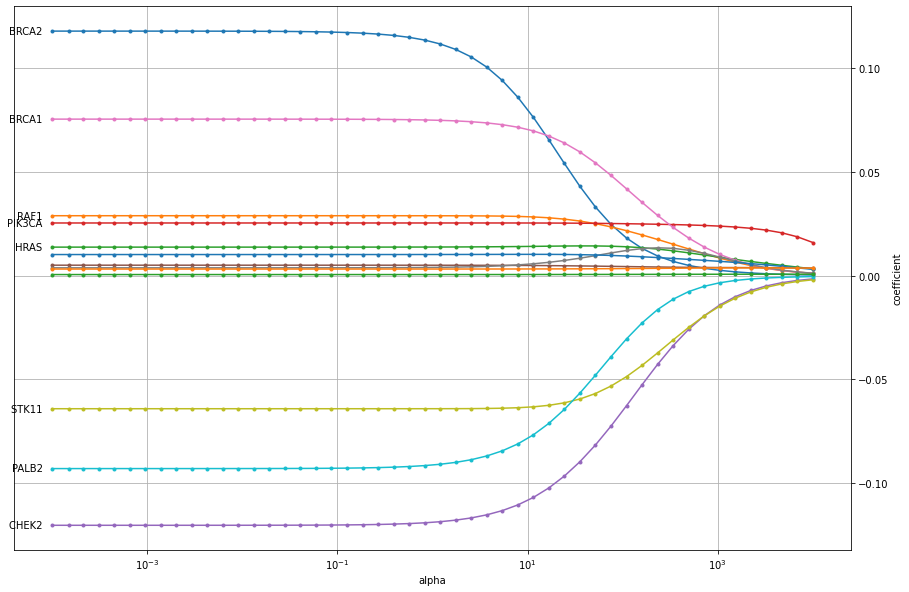

In [ ]:
plot_coefficients(coefficients, n_highlight=8)


#Multivariate (optimized )

In [ ]:
data_x = data_x_gene

In [ ]:
#not stratified COX
from sksurv.metrics import concordance_index_censored
sum_train =0
sum_test = 0
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=i)
  estimator_cox = CoxPHSurvivalAnalysis()
  estimator_cox.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = estimator_cox.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  #print("tain_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_cox.score(x_train, y_train)
  #print("test_result:", result[0])
  sum_test+=result[0]
  #print(i)

print(sum_train/5)
print(sum_test/5)

/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])


0.8912816692730262
0.8080727691635147


In [ ]:
#stratified test accuracy 
sum_test=0
sum_train=0
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      data_x,data_y,train_size=0.8,test_size=0.2,random_state=i, stratify=y_for_split)
  estimator_str = CoxPHSurvivalAnalysis()
  estimator_str.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction_str = estimator_str.predict(x_test)
  result_str = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_str)
  result_str[0]
  print("tain_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_str.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_train/5)
print(sum_test/5)


tain_result: 0.8371192565823439
test_result: 0.7972190034762456
tain_result: 0.8571057866966525
test_result: 0.7972190034762456
tain_result: 0.8580947092884905
test_result: 0.7972190034762456
tain_result: 0.8495440729483282
test_result: 0.7972190034762456
tain_result: 0.8760570186035275
test_result: 0.7972190034762456
0.8791976907600139
0.7972190034762456


In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

tumor_status_imputed          0.729446
pn                            0.697111
tumor_stage                   0.639585
pt                            0.617599
pr_status_by_ihc_imputed      0.616286
er_status_by_ihc_imputed      0.604623
menopause_status_imputed      0.585868
pm                            0.567428
CDH1                          0.566220
BRCA1                         0.554190
her2_status_by_ihc_imputed    0.552246
history_other_malignancy      0.534988
HRAS                          0.523142
RAF1                          0.513002
ERBB2                         0.508432
PIK3CA                        0.506488
BRCA2                         0.504754
CHEK2                         0.487576
PALB2                         0.483163
STK11                         0.478487
TP53                          0.472078
PTEN                          0.467350
MYC                           0.429997
dtype: float64

In [ ]:
pd.Series(estimator_str.coef_, index=x_train.columns)

history_other_malignancy      1.366345
menopause_status_imputed      0.471446
tumor_status_imputed          2.192219
er_status_by_ihc_imputed     -1.111600
pr_status_by_ihc_imputed     -0.840887
her2_status_by_ihc_imputed    1.000977
tumor_stage                  -0.446915
pt                            0.190777
pn                            0.502367
pm                            0.577973
BRCA2                        -0.059686
RAF1                          0.060866
HRAS                          0.006707
PIK3CA                        0.018142
CHEK2                        -0.187179
MYC                           0.006298
BRCA1                         0.054486
PTEN                          0.032214
STK11                        -0.048362
PALB2                         0.142479
TP53                         -0.005924
CDH1                          0.008104
ERBB2                        -0.001690
dtype: float64

#PCOX

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
#non-stratified 
#pcox test accuracy
#train with train and test with test
sum_test=0
sum_train=0
Xt=data_x
y=data_y
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      Xt,y,train_size=0.8,test_size=0.2,random_state=i)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+= cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_test/5)
print(sum_train/5)

tain_result: 0.8460945776750457
test_result: 0.7873563218390804
tain_result: 0.706319399085565
test_result: 0.6856368563685636
tain_result: 0.6901635567841511
test_result: 0.6901140684410646
tain_result: 0.7648310494510171
test_result: 0.5633640552995391
tain_result: 0.8239100817438693
test_result: 0.7589803012746235
0.6970903206445742
0.7662637329479296


In [ ]:
#non-stratified 
#pcox test accuracy
#train with train and test with test
Xt=data_x
y=data_y
x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=42)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
x_test = x_test.astype('int32')
prediction = cox_elastic_net.predict(x_test)
result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
result[0]

0.7873563218390804

In [ ]:
#pcox train accuracy
cox_elastic_net.score(x_train, y_train)

0.8460945776750457

In [ ]:
#stratified test accuracy multiple sampling 
sum_test=0
sum_train=0
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=i,stratify=y_for_split)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+=cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_test/5)
print(sum_train/5)

tain_result: 0.7859232490104974
test_result: 0.7619577308120133
tain_result: 0.762736787475132
test_result: 0.7063318777292577
tain_result: 0.8028872848417545
test_result: 0.6686838124054463
tain_result: 0.8073286052009456
test_result: 0.708185053380783
tain_result: 0.7803011999677861
test_result: 0.6306179775280899
0.6951552903711181
0.7878354252992231


In [ ]:
#stratified test accuracy
x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=42,stratify=y_for_split)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
x_test = x_test.astype('int32')
prediction = cox_elastic_net.predict(x_test)
result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
result[0]

0.7619577308120133

In [ ]:
#stratified train accuracy
cox_elastic_net.score(x_train, y_train)

0.7859232490104974

In [ ]:
cox_elastic_net.score(x_test, y_test)

0.7619577308120133

In [ ]:
import seaborn as sns
sns.set_context('talk')

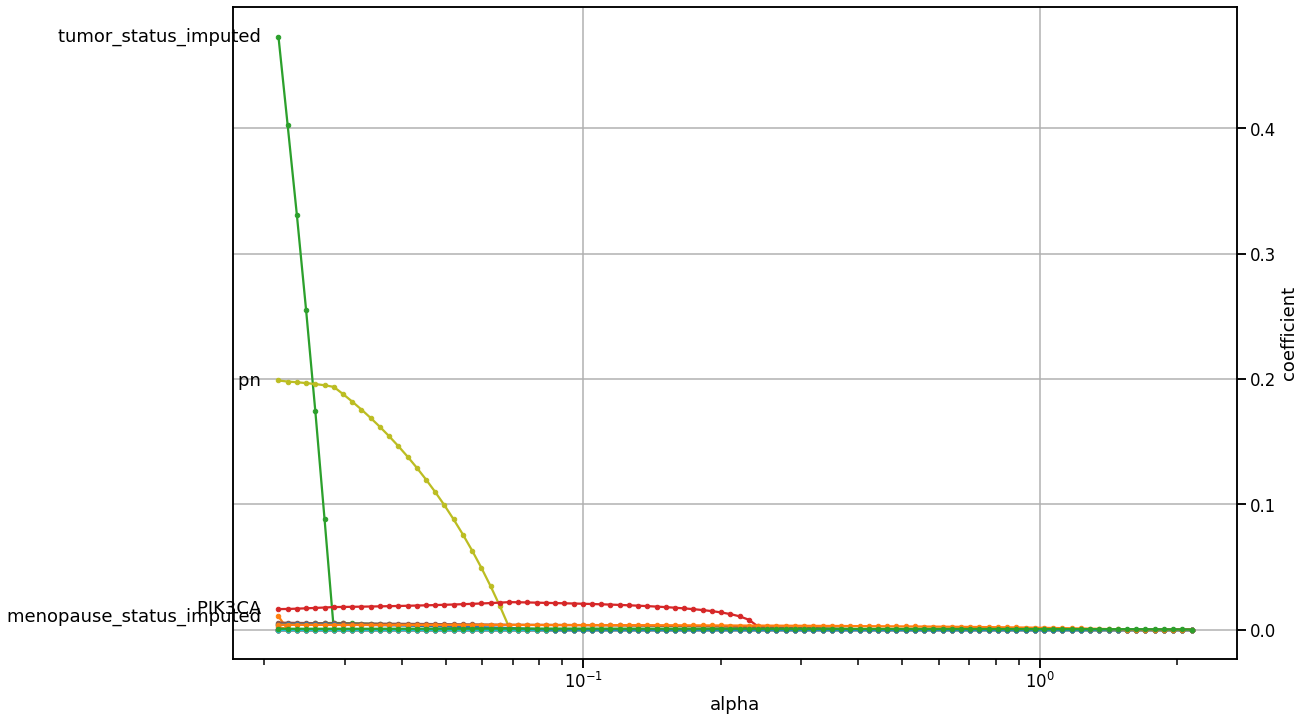

In [ ]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=Xt.columns,
    columns=np.round(cox_elastic_net.alphas_, 7)
)

plot_coefficients(coefficients_elastic_net, n_highlight=4)

In [ ]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

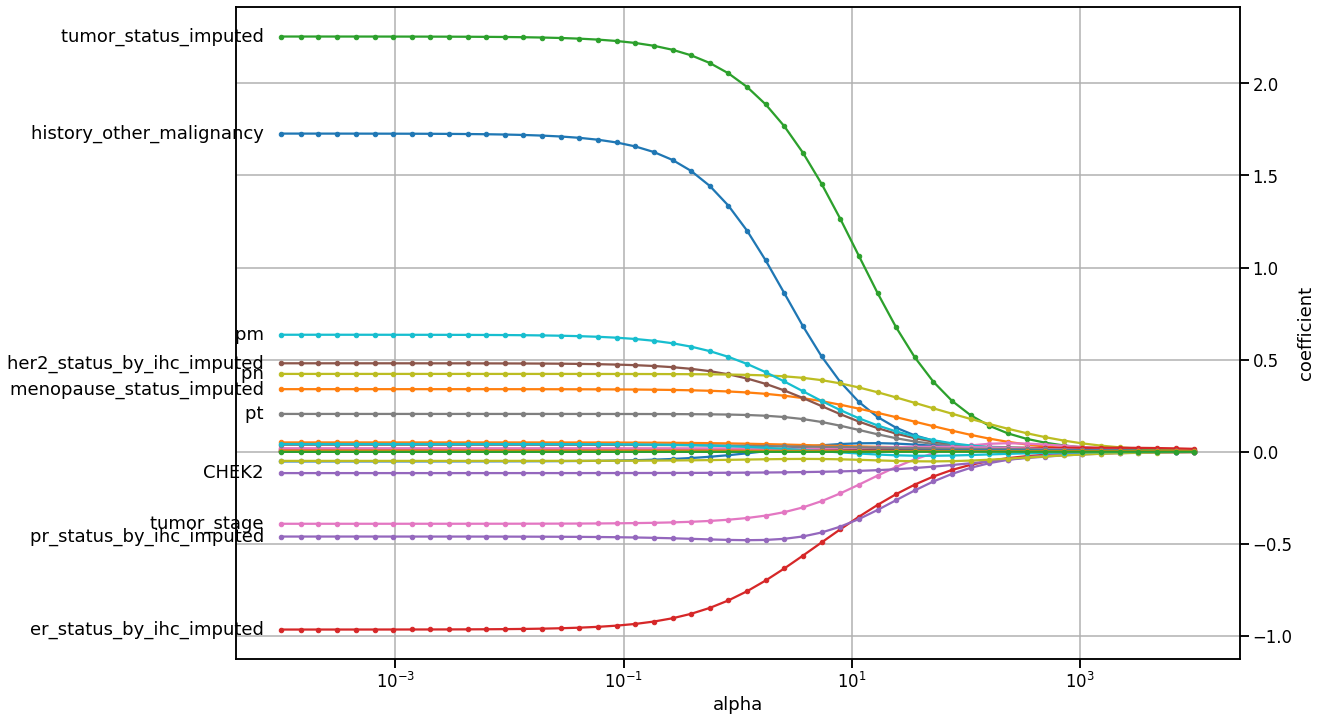

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(18, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

plot_coefficients(coefficients, n_highlight=11)